In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def fibonacci(a0, a1, n):
    seq = np.zeros(n, dtype=int)
    seq[0] = a0
    seq[1] = a1
    for i in range(2, n):
        seq[i] = seq[i-1] + seq[i-2]
    return seq

In [3]:
N = fibonacci(4, 6, 8)

In [4]:
data_enkf = np.load("Data/Lorentz63/ek.npz")
data_mpf = np.load("Data/Lorentz63/mpf.npz")
data_pk_lr = np.load("Data/Lorentz63/pk_lr.npz")
data_pk_mr = np.load("Data/Lorentz63/pk_mr.npz")
data_pk_sr = np.load("Data/Lorentz63/pk_sr.npz")
data_ka_lr = np.load("Data/Lorentz63/ka_lr.npz")
data_ka_mr = np.load("Data/Lorentz63/ka_mr.npz")
data_ka_sr = np.load("Data/Lorentz63/ka_sr.npz")

In [5]:
def load_data(data):
    X = []
    for i in range(N.shape[0]):
        X.append(data[("arr_"+str(i))])
    return X

In [6]:
ek = load_data(data_enkf)
mpf = load_data(data_mpf)
pk_lr = load_data(data_pk_lr)
pk_mr = load_data(data_pk_mr)
pk_sr = load_data(data_pk_sr)
ka_lr = load_data(data_ka_lr)
ka_mr = load_data(data_ka_mr)
ka_sr = load_data(data_ka_sr)

In [7]:
def stats_computing_true(X):
    N = X.shape[-1]
    mu = np.mean(X, axis=2)
    X_c = X - mu[:,:,None]
    P = np.einsum('nim,njm->nij', X_c, X_c) / (N - 1) # 1+N_assi, d, d
    return mu, np.einsum('nkk->n', P)
def stats_computing(X):
    N = X.shape[-1]
    mu = np.mean(X, axis=3)
    X_c = X - mu[:,:,:,None]
    P = np.einsum('anim,anjm->anij', X_c, X_c) / (N - 1) # N_exp, 1+N_assi, d, d
    return mu, np.einsum('mnkk->mn', P)

In [8]:
def rout(X, threshold = 10):
    filtered = X[X < threshold]
    return filtered

In [9]:
def stats_data(X, mu_true, P_true, N_count = 20):
    mask = ~np.isnan(X).any(axis=(1,2,3))
    X_clean = X[mask]

    X_clean = X
    mu_X, P_X = stats_computing(X_clean) # N_exp, 1+N_assi
    mu_X_count = mu_X[:,N_count:,:]
    P_X_count = P_X[:,N_count:]
    mu_true_count = mu_true[N_count:, :]
    P_true_count = P_true[N_count:]
    error_mu = np.mean(np.sqrt(np.mean((mu_X_count - mu_true_count[None,:,:]) ** 2, axis = 2)), axis = 1)
    error_P = np.mean(np.abs(P_X_count - P_true_count[None,:]), axis = 1)
 
    R_mu = rout(error_mu)
    R_P = rout(error_P)
    return np.mean(R_mu), np.mean(R_P)

In [10]:
def organize_data(L, mu, P):
    e_mu = np.zeros(N.shape[0])
    e_P = np.zeros(N.shape[0])
    for i in range(N.shape[0]):
        a, b = stats_data(L[i], mu, P, N_count = 20)
        e_mu[i] = a
        e_P[i] = b
    return e_mu, e_P

In [11]:
X_true = np.load("Data/Lorentz63/pf.npy")

In [12]:
mu_t, P_t = stats_computing_true(X_true)

In [13]:
e_mu_ek, e_P_ek = organize_data(ek, mu_t, P_t)
e_mu_mpf, e_P_mpf = organize_data(mpf, mu_t, P_t)

In [14]:
e_mu_pk_lr, e_P_pk_lr = organize_data(pk_lr, mu_t, P_t)
e_mu_pk_mr, e_P_pk_mr = organize_data(pk_mr, mu_t, P_t)
e_mu_pk_sr, e_P_pk_sr = organize_data(pk_sr, mu_t, P_t)

In [15]:
e_mu_ka_lr, e_P_ka_lr = organize_data(ka_lr, mu_t, P_t)
e_mu_ka_mr, e_P_ka_mr = organize_data(ka_mr, mu_t, P_t)
e_mu_ka_sr, e_P_ka_sr = organize_data(ka_sr, mu_t, P_t)

In [16]:
# --- Global style settings (optional but recommended) ---
plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "lines.linewidth": 2,
})

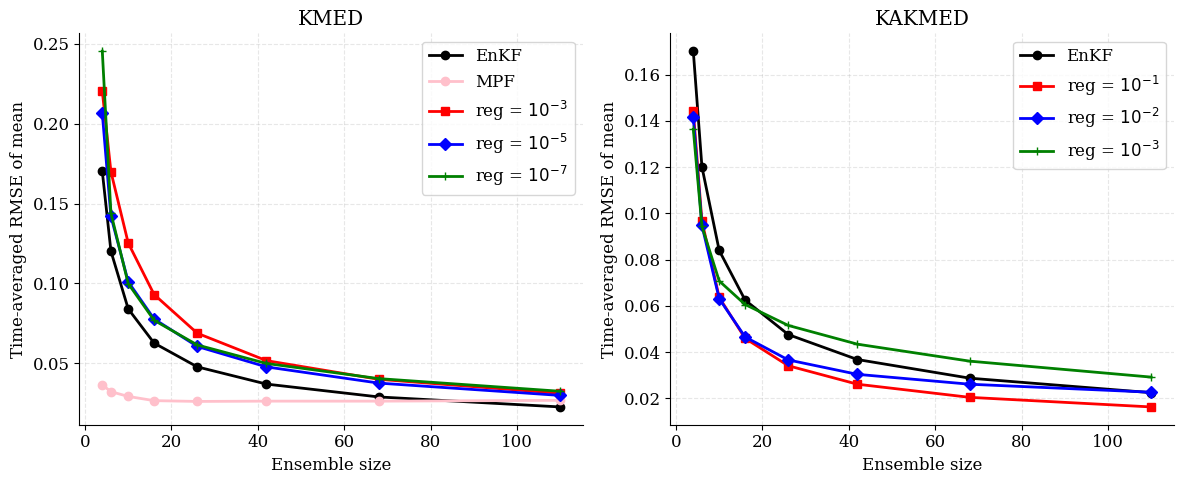

In [17]:
# --- Create figure with 3 subplots ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
 
# --- Subplot 1 ---
axs[0].plot(N, e_mu_ek, color = "black", label = "EnKF", marker = "o")
axs[0].plot(N, e_mu_mpf, color = "pink", label = "MPF", marker = "o")
axs[0].plot(N, e_mu_pk_lr, color = "red", label = "reg = $10^{-3}$", marker = "s")
axs[0].plot(N, e_mu_pk_mr, color = "blue", label = "reg = $10^{-5}$", marker = "D")
axs[0].plot(N, e_mu_pk_sr, color = "green", label = "reg = $10^{-7}$", marker = "+")
axs[0].set_ylabel("Time-averaged RMSE of mean")
axs[0].set_xlabel("Ensemble size")
axs[0].set_title("KMED")
axs[0].legend()
 
# --- Subplot 2 ---
axs[1].plot(N, e_mu_ek, color = "black", label = "EnKF", marker = "o")
# axs[1].plot(N, e_mu_mpf, color = "pink", label = "MPF", marker = "o")
axs[1].plot(N, e_mu_ka_lr, color = "red", label = "reg = $10^{-1}$", marker = "s")
axs[1].plot(N, e_mu_ka_mr, color = "blue", label = "reg = $10^{-2}$", marker = "D")
axs[1].plot(N, e_mu_ka_sr, color = "green", label = "reg = $10^{-3}$", marker = "+")
axs[1].set_ylabel("Time-averaged RMSE of mean")
axs[1].set_xlabel("Ensemble size")
axs[1].set_title("KAKMED")
axs[1].legend()

# --- Layout ---
fig.tight_layout()
plt.show()

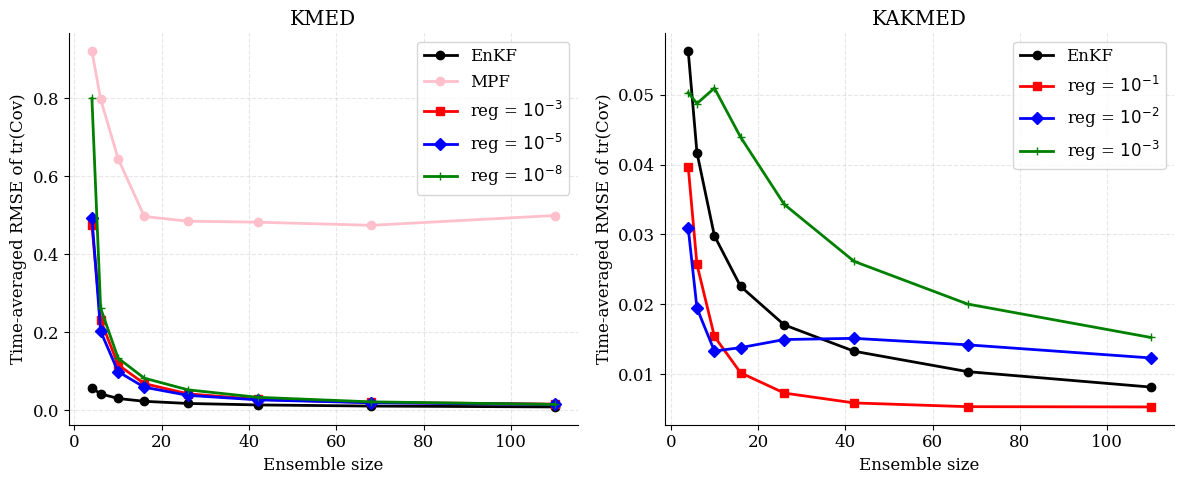

In [18]:
# --- Create figure with 3 subplots ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
 
# --- Subplot 1 ---
axs[0].plot(N, e_P_ek, color = "black", label = "EnKF", marker = "o")
axs[0].plot(N, e_P_mpf, color = "pink", label = "MPF", marker = "o")
axs[0].plot(N, e_P_pk_lr, color = "red", label = "reg = $10^{-3}$", marker = "s")
axs[0].plot(N, e_P_pk_mr, color = "blue", label = "reg = $10^{-5}$", marker = "D")
axs[0].plot(N, e_P_pk_sr, color = "green", label = "reg = $10^{-8}$", marker = "+")
axs[0].set_ylabel("Time-averaged RMSE of tr(Cov)")
axs[0].set_xlabel("Ensemble size")
axs[0].set_title("KMED")
axs[0].legend()
 
# --- Subplot 2 ---
axs[1].plot(N, e_P_ek, color = "black", label = "EnKF", marker = "o")
axs[1].plot(N, e_P_ka_lr, color = "red", label = "reg = $10^{-1}$", marker = "s")
axs[1].plot(N, e_P_ka_mr, color = "blue", label = "reg = $10^{-2}$", marker = "D")
axs[1].plot(N, e_P_ka_sr, color = "green", label = "reg = $10^{-3}$", marker = "+")
axs[1].set_ylabel("Time-averaged RMSE of tr(Cov)")
axs[1].set_xlabel("Ensemble size")
axs[1].set_title("KAKMED")
axs[1].legend()

# --- Layout ---
fig.tight_layout()
plt.show()

In [20]:
data = np.zeros((8, e_mu_ek.shape[0]))
data[0,:] = e_mu_ek
data[1,:] = e_mu_pk_lr
data[2,:] = e_mu_pk_mr
data[3,:] = e_mu_pk_sr
data[4,:] = e_mu_ka_lr
data[5,:] = e_mu_ka_mr
data[6,:] = e_mu_ka_sr
data[7,:] = e_mu_mpf

col_names = [f"N = {n}" for n in N]

row_labels = ["EnKF", "KMED, reg = $10^{-3}$", "KMED, reg = $10^{-5}$", "KMED, reg = $10^{-7}$", "KAKMED, reg = $10^{-1}$", "KAKMED, reg = $10^{-2}$", "KAKMED, reg = $10^{-3}$", "MPF"]

df = pd.DataFrame(data, columns=col_names)
df.insert(0, " ", row_labels)   # first column as row labels
latex_code = df.to_latex(index=False)

print(latex_code)

\begin{tabular}{lrrrrrrrr}
\toprule
  & N = 4 & N = 6 & N = 10 & N = 16 & N = 26 & N = 42 & N = 68 & N = 110 \\
\midrule
EnKF & 0.170140 & 0.120131 & 0.083958 & 0.062504 & 0.047600 & 0.036815 & 0.028758 & 0.022492 \\
KMED, reg = $10^{-3}$ & 0.220446 & 0.169925 & 0.125265 & 0.092941 & 0.068677 & 0.051521 & 0.039810 & 0.031037 \\
KMED, reg = $10^{-5}$ & 0.206527 & 0.141963 & 0.100983 & 0.077625 & 0.060391 & 0.047595 & 0.037438 & 0.029715 \\
KMED, reg = $10^{-7}$ & 0.245530 & 0.143962 & 0.099816 & 0.076792 & 0.061332 & 0.049742 & 0.040247 & 0.032313 \\
KAKMED, reg = $10^{-1}$ & 0.144273 & 0.096695 & 0.063685 & 0.045968 & 0.034122 & 0.026144 & 0.020470 & 0.016326 \\
KAKMED, reg = $10^{-2}$ & 0.141494 & 0.094792 & 0.063081 & 0.046575 & 0.036639 & 0.030416 & 0.026145 & 0.022686 \\
KAKMED, reg = $10^{-3}$ & 0.136396 & 0.094370 & 0.070780 & 0.060603 & 0.051550 & 0.043454 & 0.036117 & 0.029223 \\
MPF & 0.036316 & 0.032060 & 0.029078 & 0.026429 & 0.025940 & 0.026122 & 0.026107 & 0.026629 \\
\bot

In [21]:
data = np.zeros((8, e_P_ek.shape[0]))
data[0,:] = e_P_ek
data[1,:] = e_P_pk_lr
data[2,:] = e_P_pk_mr
data[3,:] = e_P_pk_sr
data[4,:] = e_P_ka_lr
data[5,:] = e_P_ka_mr
data[6,:] = e_P_ka_sr
data[7,:] = e_P_mpf

col_names = [f"N = {n}" for n in N]

row_labels = ["EnKF", "KMED, reg = $10^{-3}$", "KMED, reg = $10^{-5}$", "KMED, reg = $10^{-7}$", "KAKMED, reg = $10^{-1}$", "KAKMED, reg = $10^{-2}$", "KAKMED, reg = $10^{-3}$", "MPF"]

df = pd.DataFrame(data, columns=col_names)
df.insert(0, " ", row_labels)   # first column as row labels
latex_code = df.to_latex(index=False)

print(latex_code)

\begin{tabular}{lrrrrrrrr}
\toprule
  & N = 4 & N = 6 & N = 10 & N = 16 & N = 26 & N = 42 & N = 68 & N = 110 \\
\midrule
EnKF & 0.056246 & 0.041719 & 0.029808 & 0.022568 & 0.017057 & 0.013287 & 0.010368 & 0.008155 \\
KMED, reg = $10^{-3}$ & 0.474120 & 0.230791 & 0.116039 & 0.067996 & 0.041825 & 0.027407 & 0.019625 & 0.015349 \\
KMED, reg = $10^{-5}$ & 0.492998 & 0.201968 & 0.098615 & 0.058760 & 0.037850 & 0.026354 & 0.018850 & 0.014537 \\
KMED, reg = $10^{-7}$ & 0.799239 & 0.261222 & 0.133192 & 0.081937 & 0.052003 & 0.032838 & 0.021166 & 0.014637 \\
KAKMED, reg = $10^{-1}$ & 0.039687 & 0.025705 & 0.015409 & 0.010203 & 0.007299 & 0.005887 & 0.005351 & 0.005314 \\
KAKMED, reg = $10^{-2}$ & 0.030900 & 0.019452 & 0.013313 & 0.013803 & 0.014962 & 0.015132 & 0.014205 & 0.012326 \\
KAKMED, reg = $10^{-3}$ & 0.050316 & 0.048747 & 0.050953 & 0.043933 & 0.034308 & 0.026154 & 0.020042 & 0.015257 \\
MPF & 0.920451 & 0.797009 & 0.644888 & 0.496619 & 0.484416 & 0.481849 & 0.473819 & 0.498983 \\
\bot